In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade tensorflow keras

In [61]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from functools import partial

In [109]:
# 이미지 크기 및 배치 크기 설정
img_height = 244
img_width = 244
batch_size = 32

In [65]:
pwd

'C:\\Users\\hongj\\Ai_test'

In [11]:
cd ..

C:\Users\hongj\Ai_test


In [137]:
# 데이터셋 로드
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./image_data/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 418 files belonging to 5 classes.
Using 335 files for training.


In [139]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./image_data/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 418 files belonging to 5 classes.
Using 83 files for validation.


In [145]:
class_names = train_ds.class_names
print(class_names)


['cans', 'glass', 'other_ps', 'p_bowls', 'pets']


In [147]:
# 데이터 증식을 위한 레이어
data_augmentation = Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),  # 좌우 반전
  layers.RandomRotation(0.1),    # 회전
  layers.RandomZoom(0.1),        # 확대/축소
  layers.RandomBrightness(0.1)   # 밝기 조절
])

In [119]:
# 정규화: 픽셀 값을 [0, 255] -> [0, 1] 범위로 변환
normalization_layer = layers.Rescaling(1./255)

# 학습 데이터에 전처리 및 증식 적용
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# 검증 데이터에도 정규화 적용 (증식은 학습 데이터에만 적용)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [121]:
# 데이터셋을 성능 향상을 위해 Prefetch 적용
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [171]:
# EfficientNetB0 모델 불러오기 (사전 훈련된 가중치 사용)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

In [173]:
# 모델의 일부 층은 고정
base_model.trainable = False


In [175]:
# 전체 모델 구성
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])


In [177]:
base_model.trainable = True  # 미세 조정할 때 True로 설정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [179]:
# EarlyStopping과 LearningRateScheduler 정의
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10 ** (epoch / 20)
)

In [ ]:
# 모델 학습 (콜백 추가)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  
    callbacks=[early_stopping, lr_scheduler]  # 콜백 추가
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.1524 - loss: 1.7018 - val_accuracy: 0.1928 - val_loss: 1.6725 - learning_rate: 1.0000e-05
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.1974 - loss: 1.6828 - val_accuracy: 0.2289 - val_loss: 1.6276 - learning_rate: 1.1220e-05
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.2316 - loss: 1.6401 - val_accuracy: 0.2289 - val_loss: 1.5821 - learning_rate: 1.2589e-05
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.2878 - loss: 1.5742 - val_accuracy: 0.2530 - val_loss: 1.5351 - learning_rate: 1.4125e-05
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.3156 - loss: 1.5328 - val_accuracy: 0.3253 - val_loss: 1.4847 - learning_rate: 1.5849e-05
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.3934 - loss: 1.4413 - val_accuracy: 0.3614 - val_loss: 1.4272 - learning_rate: 1.7783e-05
Epoch 7/20
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:01 6s/step - accuracy: 0.3125 - los

In [161]:
# 검증 정확도 확인
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step - accuracy: 0.8734 - loss: 0.3615
Validation accuracy: 0.8795180916786194


In [163]:
model.summary() #모델의 구조

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 8, 8, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,558,508 (47.91 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,344,324 (31.83 MB)

In [165]:
# 새로운 이미지 예측
img = image.load_img('C:/Users/hongj/ArtificialIntelligence/검증이미지/찌그러진캔.jpg', target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # 배치 차원 추가
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: cans


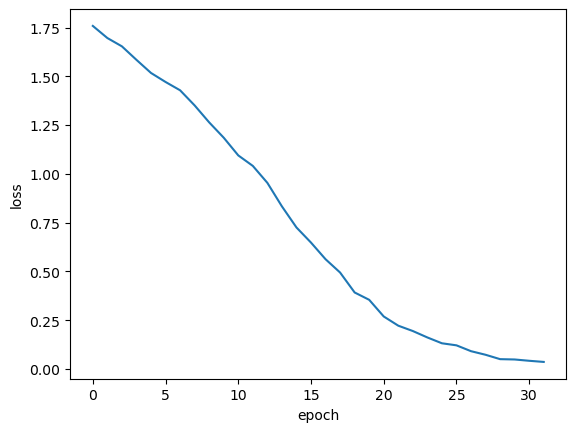

In [167]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#손실

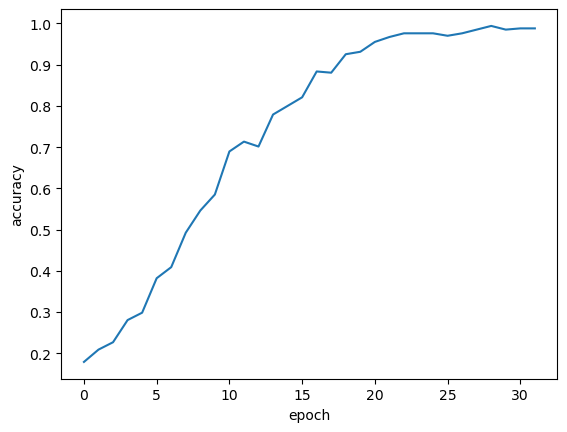

In [169]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()